<a href="https://colab.research.google.com/github/hazanyucel/Medikal-Goruntu-Isleme-medical-image-processing-/blob/main/TransUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ===============================
# 1. KÜTÜPHANELER VE KURULUM
# ===============================
import os
import sys
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# TransUNet Reposunu Çekiyoruz (Eğer yoksa)
if not os.path.exists('/content/TransUNet'):
    !git clone https://github.com/Beckschen/TransUNet.git

# Gerekli kütüphaneleri yükle
!pip install ml_collections

sys.path.append('/content/TransUNet')

from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg

# GPU Kontrolü
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Kullanılan Cihaz: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 6.0 MB/s eta 0:00:00
🚀 Kullanılan Cihaz: cuda


In [5]:
from google.colab import drive
# 1. Google Drive'ı Bağla
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# ===============================
# 2. AYARLAR (CONFIG - AYNISI)
# ===============================
DATASET_PATH = "/content/drive/MyDrive/Medgoris/archive/ACDC_preprocessed/ACDC_training_slices"

BATCH_SIZE = 16
EPOCHS = 40       # Senin isteğin
LR = 1e-4
TARGET_SIZE = (256, 256) # Senin isteğin

In [7]:
# ===============================
# 3. DATASET CLASS (GÜNCELLENDİ)
# ===============================
class ACDCSliceDataset(Dataset):
    def __init__(self, root_dir, target_size=(256, 256)):
        self.files = sorted([
            os.path.join(root_dir, f)
            for f in os.listdir(root_dir)
            if f.endswith(".h5")
        ])
        self.target_size = target_size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        try:
            with h5py.File(self.files[idx], 'r') as f:
                keys = list(f.keys())
                img_key = 'image' if 'image' in keys else keys[0]
                lbl_key = 'label' if 'label' in keys else keys[1]

                image = f[img_key][:]
                label = f[lbl_key][:]
        except Exception as e:
            print(f"Hata: {self.files[idx]} - {e}")
            return torch.zeros((3, *self.target_size)), torch.zeros(self.target_size)

        # Numpy -> Tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) # (1, H, W)
        label = torch.tensor(label, dtype=torch.long).unsqueeze(0)

        # 1. Resize (Boyut Eşitleme)
        image = F.interpolate(image.unsqueeze(0), size=self.target_size, mode="bilinear", align_corners=False).squeeze(0)
        label = F.interpolate(label.unsqueeze(0).float(), size=self.target_size, mode="nearest").squeeze(0).long()

        # 2. Normalizasyon
        if image.max() > 0:
            image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # *** TRANSUNET ÖZEL: 1 Kanalı 3 Kanala Çeviriyoruz ***
        # TransUNet (ImageNet pre-trained) 3 kanal bekler.
        image = image.repeat(3, 1, 1)

        return image, label.squeeze(0)

In [8]:
# ===============================
# 4. LOSS & METRİKLER (AYNISI)
# ===============================
def dice_loss(pred, target, eps=1e-6):
    pred = torch.softmax(pred, dim=1)
    target_onehot = F.one_hot(target, num_classes=4).permute(0,3,1,2).float()
    inter = (pred * target_onehot).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target_onehot.sum(dim=(2,3))
    dice = (2 * inter + eps) / (union + eps)
    return 1 - dice[:, 1:].mean()

def calculate_dice_metric(pred, target, num_classes=4):
    dices = []
    pred = torch.argmax(pred, dim=1)
    for cls in range(1, num_classes):
        pred_c = (pred == cls).float()
        target_c = (target == cls).float()
        inter = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice = (2 * inter + 1e-6) / (union + 1e-6)
        dices.append(dice.item())
    return np.mean(dices)

In [9]:
# ===============================
# 5. MODEL HAZIRLIĞI
# ===============================
if not os.path.exists(DATASET_PATH):
    print(f"⚠️ HATA: '{DATASET_PATH}' klasörü bulunamadı!")
else:
    print("📂 Veri seti dosyaları taranıyor...")
    full_dataset = ACDCSliceDataset(DATASET_PATH, target_size=TARGET_SIZE)

    if len(full_dataset) == 0:
        print("⚠️ HATA: Klasörde .h5 dosyası bulunamadı!")
    else:
        train_size = int(0.85 * len(full_dataset))
        val_size = len(full_dataset) - train_size
        train_ds, val_ds = random_split(full_dataset, [train_size, val_size])

        print(f"✅ Veri Hazır -> Eğitim: {len(train_ds)} | Doğrulama: {len(val_ds)}")

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
        val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

        # --- TRANSUNET MODEL AYARLARI ---
        config_vit = CONFIGS_ViT_seg['R50-ViT-B_16']
        config_vit.n_classes = 4
        config_vit.n_skip = 3

        # Grid ayarı: 256 / 16 = 16. Grid (16, 16) olmalı.
        config_vit.patches.grid = (int(TARGET_SIZE[0] / 16), int(TARGET_SIZE[1] / 16))

        # Modeli Başlat
        model = ViT_seg(config_vit, img_size=TARGET_SIZE[0], num_classes=4).to(device)

        # Optimizer ve Loss (Senin ayarların)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5)

📂 Veri seti dosyaları taranıyor...
✅ Veri Hazır -> Eğitim: 1625 | Doğrulama: 287


In [12]:
# ===============================
# 6. EĞİTİM DÖNGÜSÜ (AYNISI)
# ===============================
best_val_dice = 0.0
print(f"\n🔥 TransUNet Eğitimi Başlıyor ({EPOCHS} Epoch)...")

for epoch in range(EPOCHS):
    # --- TRAINING ---
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for img, lbl in loop:
        img, lbl = img.to(device), lbl.to(device)

        optimizer.zero_grad()
        out = model(img)

        loss = criterion(out, lbl) + dice_loss(out, lbl)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = epoch_loss / len(train_loader)


🔥 TransUNet Eğitimi Başlıyor (40 Epoch)...


Epoch 40/40: 100%|██████████| 102/102 [01:54<00:00,  1.12s/it, loss=0.0829]


In [16]:
    # --- VALIDATION ---
    model.eval()
    val_dice_score = 0
    with torch.no_grad():
        for img, lbl in val_loader:
            img, lbl = img.to(device), lbl.to(device)
            out = model(img)
            val_dice_score += calculate_dice_metric(out, lbl)

    avg_val_dice = val_dice_score / len(val_loader)

    # Scheduler Adımı
    scheduler.step(avg_val_dice)
    curr_lr = optimizer.param_groups[0]['lr']

    print(f"Epoch {epoch+1} -> Loss: {avg_train_loss:.4f} | Val Dice: {avg_val_dice:.4f} | LR: {curr_lr:.6f}")

    if avg_val_dice > best_val_dice:
        best_val_dice = avg_val_dice
        torch.save(model.state_dict(), "best_transunet.pth")
        print("💾 Model Kaydedildi (New Best)!")

print(f"\n🏆 En İyi Validation Dice Skoru: {best_val_dice:.4f}")

Epoch 40 -> Loss: 0.1398 | Val Dice: 0.9146 | LR: 0.000100
💾 Model Kaydedildi (New Best)!

🏆 En İyi Validation Dice Skoru: 0.9146



🖼️ Sonuçlar Çiziliyor...


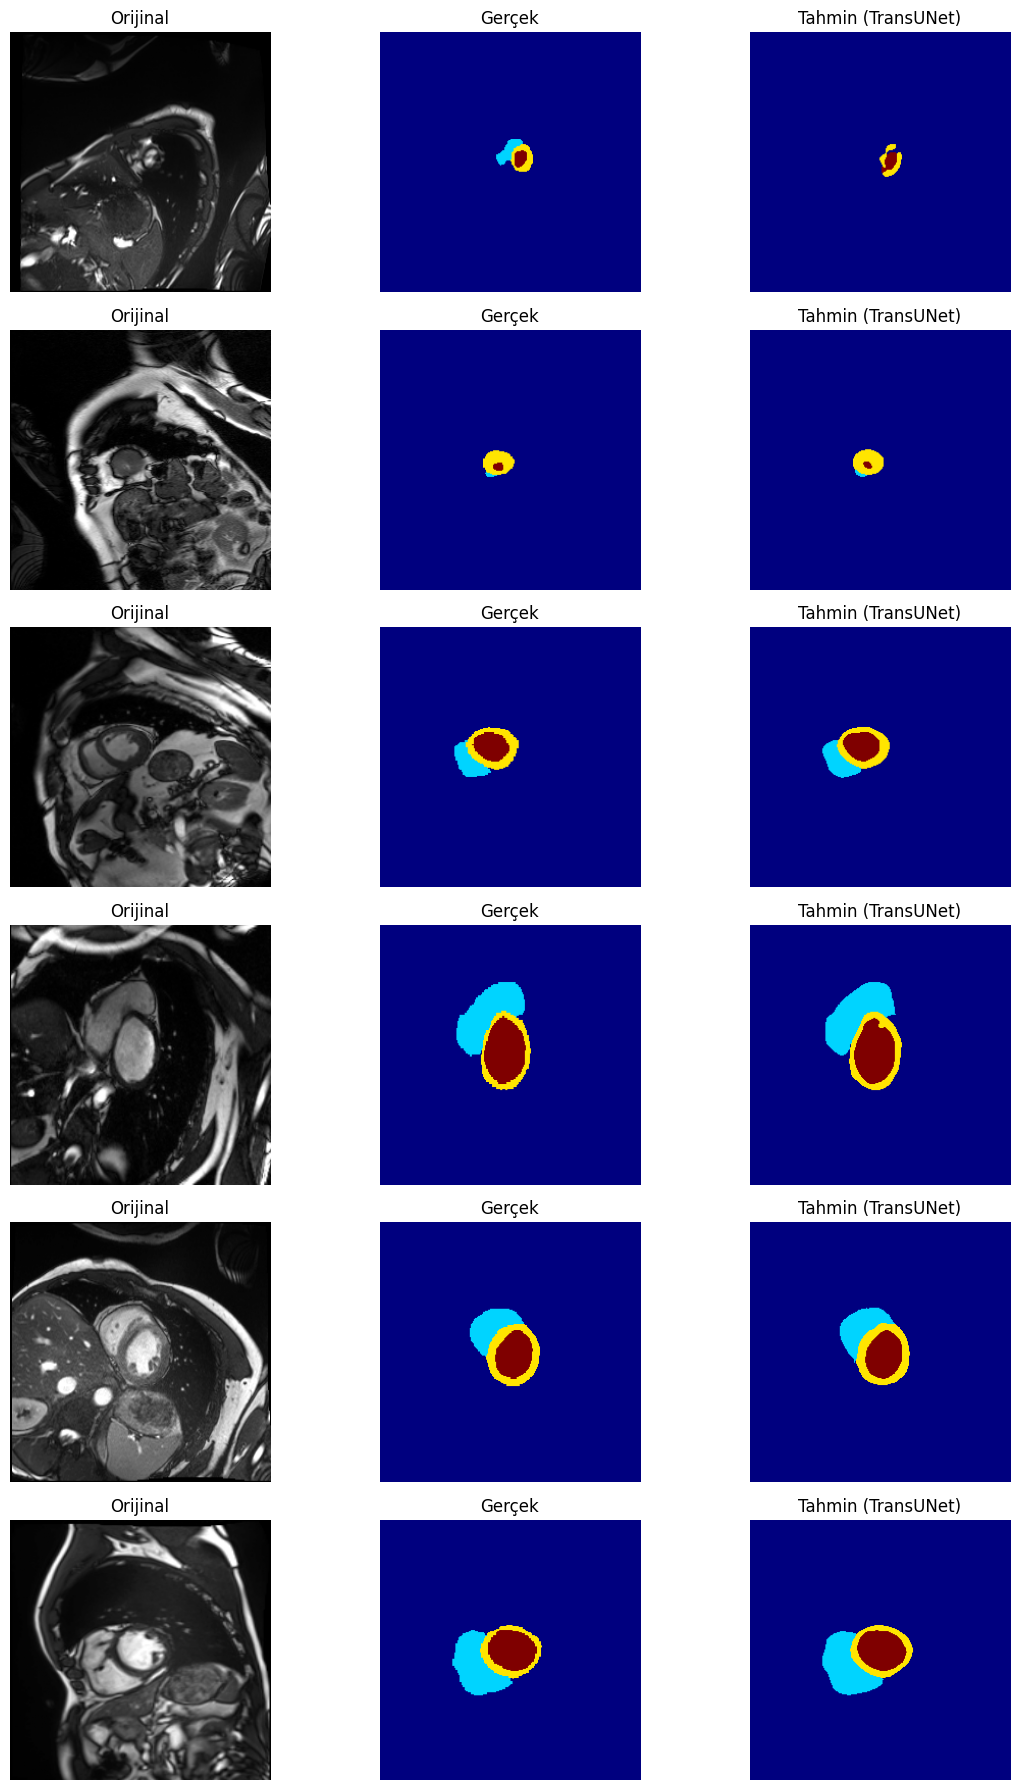

In [19]:
# ===============================
# 7. SONUÇLARI GÖRSELLEŞTİRME
# ===============================
print("\n🖼️ Sonuçlar Çiziliyor...")
model.load_state_dict(torch.load("best_transunet.pth"))
model.eval()

indices = np.random.choice(len(val_ds), 6, replace=False)
plt.figure(figsize=(12, 18))

for i, idx in enumerate(indices):
    img, lbl = val_ds[idx]
    with torch.no_grad():
        input_tensor = img.unsqueeze(0).to(device)
        pred_logits = model(input_tensor)
        pred_mask = torch.argmax(pred_logits, dim=1).squeeze(0).cpu().numpy()

    # Görselleştirme için ilk kanalı al (Zaten 3 kanal birbirinin aynısı)
    img_np = img[0].numpy()
    lbl_np = lbl.numpy()

    plt.subplot(6, 3, i*3 + 1)
    plt.imshow(img_np, cmap="gray")
    plt.title("Orijinal")
    plt.axis("off")

    plt.subplot(6, 3, i*3 + 2)
    plt.imshow(lbl_np, cmap="jet", vmin=0, vmax=3)
    plt.title("Gerçek")
    plt.axis("off")

    plt.subplot(6, 3, i*3 + 3)
    plt.imshow(pred_mask, cmap="jet", vmin=0, vmax=3)
    plt.title("Tahmin (TransUNet)")
    plt.axis("off")

plt.tight_layout()
plt.show()